In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [0]:
!curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
!apt-get install ffmpeg
# restart kernel after install

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from fastai import *
from fastai.vision import *

In [0]:
from fastai import version as fastai_version

In [0]:
print(f'fastai version -> {fastai_version.__version__}')

fastai version -> 1.0.32


In [0]:
bs = 32  #batch size

In [0]:
path = untar_data(URLs.PETS)/'images'

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=.2, p_lighting=.2)
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

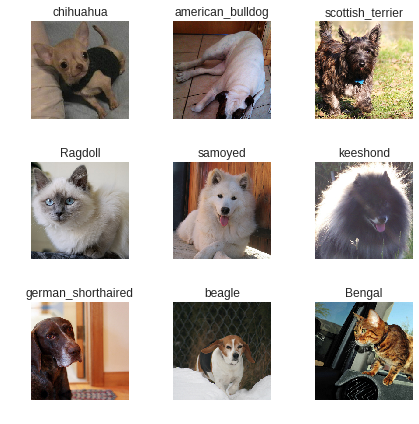

In [0]:
data = get_data(224, bs)
data.show_batch(rows=3, figsize=(6,6))

In [0]:
data = get_data(352,16)

In [0]:
# !ls {path/'models'}
# !cp {path/'models/352.pth'} {DRIVE_BASE_PATH}saved_models/fastai/pets_more/
# !cp {DRIVE_BASE_PATH}saved_models/fastai/pets_more/352.pth {path/'models/'}
# !ls {path/'models/'}

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.model[0][0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [0]:
learn.model[0][4][0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Forward pass heat-maps along the network


class name: miniature_pinscher
class_index: 26


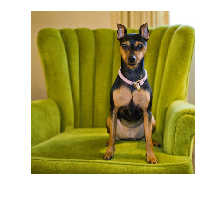

In [0]:
idx=4
x,y = data.valid_ds[idx]
x.show()
print(f'class name: {y}\nclass_index: {y.data}')

In [0]:
from fastai.callbacks.hooks import *

In [0]:
m = learn.model.eval();

In [0]:
xb,_ = data.one_item(x)    #get tensor from Image x
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
def non_class_discriminative_activations_multi(xb):
    hooks = []
    layer_names = []
    
    hooks.append(hook_output(m[0][3]))
    layer_names.append('first conv')

    for ind in [4,5,6,7]:
        for i,el in enumerate(learn.model[0][ind]):
            hooks.append(hook_output(el))
            layer_names.append(f'layer-{ind-3} - conv-{i+1}')
            # layer 1 (layer is combination of resnet blocks) is model[0][4]
    
    preds = m(xb)
    
    for hook in hooks:
        hook.remove()
    
    return hooks,layer_names

In [0]:
hooks,layer_names = non_class_discriminative_activations_multi(xb)

In [0]:
for layer_name,hook in zip(layer_names,hooks):
    print(f'{layer_name}{" "*(18-len(layer_name))} -->   {hook.stored[0].shape}')

first conv         -->   torch.Size([64, 88, 88])
layer-1 - conv-1   -->   torch.Size([64, 88, 88])
layer-1 - conv-2   -->   torch.Size([64, 88, 88])
layer-1 - conv-3   -->   torch.Size([64, 88, 88])
layer-2 - conv-1   -->   torch.Size([128, 44, 44])
layer-2 - conv-2   -->   torch.Size([128, 44, 44])
layer-2 - conv-3   -->   torch.Size([128, 44, 44])
layer-2 - conv-4   -->   torch.Size([128, 44, 44])
layer-3 - conv-1   -->   torch.Size([256, 22, 22])
layer-3 - conv-2   -->   torch.Size([256, 22, 22])
layer-3 - conv-3   -->   torch.Size([256, 22, 22])
layer-3 - conv-4   -->   torch.Size([256, 22, 22])
layer-3 - conv-5   -->   torch.Size([256, 22, 22])
layer-3 - conv-6   -->   torch.Size([256, 22, 22])
layer-4 - conv-1   -->   torch.Size([512, 11, 11])
layer-4 - conv-2   -->   torch.Size([512, 11, 11])
layer-4 - conv-3   -->   torch.Size([512, 11, 11])


In [0]:
acts  = hooks[0].stored[0].cpu()
acts.shape

torch.Size([64, 88, 88])

Averaging the values of these activations over the channel axis to get a 2 dimensional tensor.

In [0]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([88, 88])

Plotting these averaged activations.

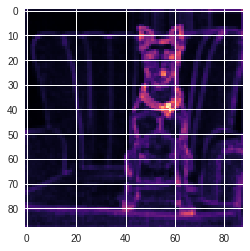

In [0]:
plt.imshow(avg_acts, cmap='magma');

In [0]:
from math import ceil

Plotting all of the stored activations.

In [0]:
def plot_forward_activations_multi(hooks):
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts  = hooks[ind].stored[0].cpu()
            avg_acts = acts.mean(0)

            ax[i,j].imshow(avg_acts, cmap='magma')
            ind+=1
            
    plt.show()

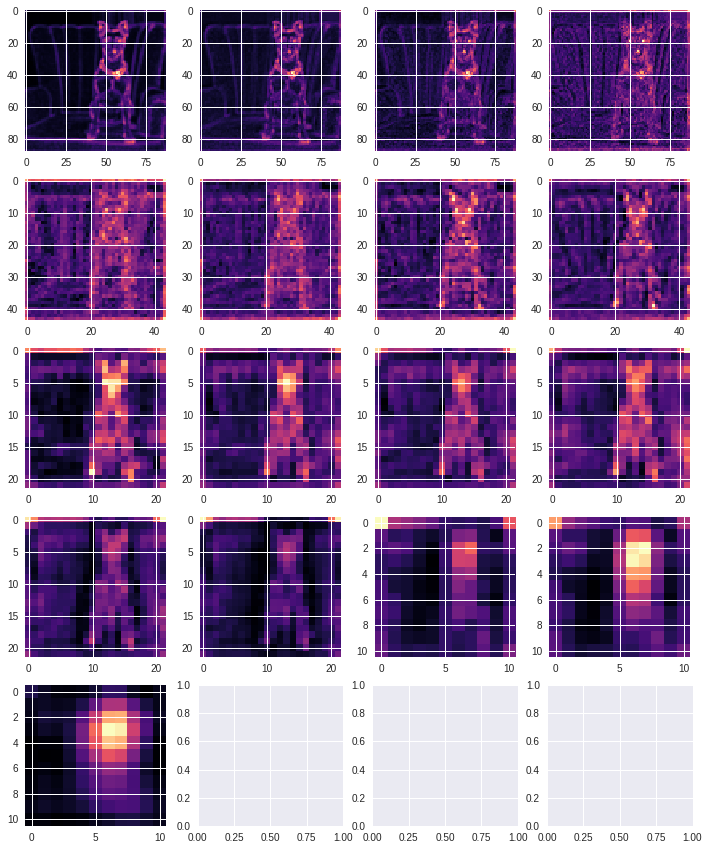

In [0]:
plot_forward_activations_multi(hooks)

Plotting heat-maps based on these activations by extrapolating them to the size of the input image.

In [0]:
def plot_non_class_discriminative_heatmaps_multi(x):
    
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    hooks,_ = non_class_discriminative_activations_multi(xb)
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts  = hooks[ind].stored[0].cpu()
            avg_acts = acts.mean(0)

            xb_im.show(ax[i,j])
            ax[i,j].imshow(avg_acts, alpha=0.6, extent=(0,352,352,0),
                      interpolation='bilinear', cmap='magma');
            ind+=1
            
    plt.show()

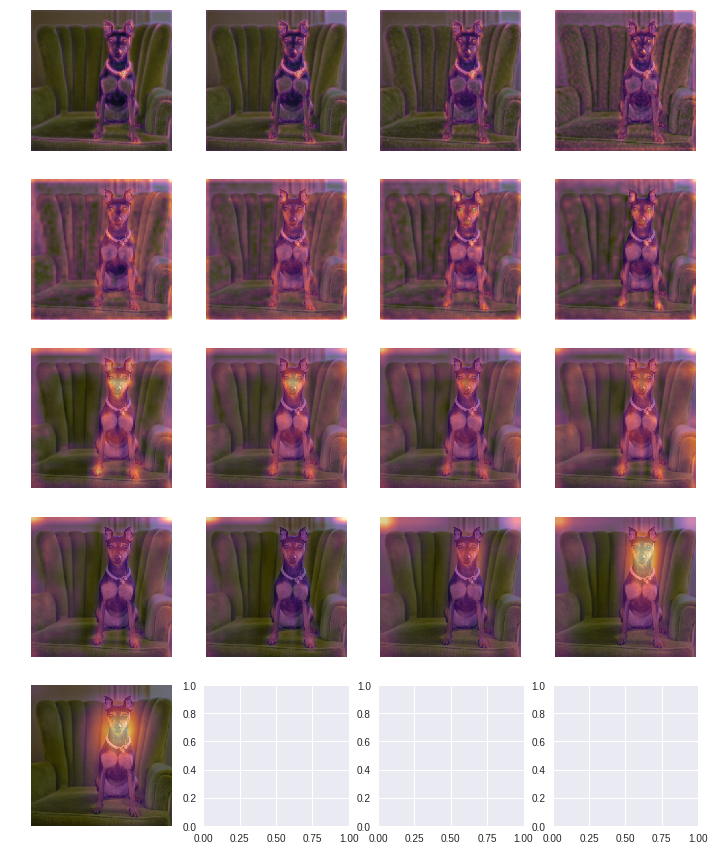

In [0]:
plot_non_class_discriminative_heatmaps_multi(x)

In [0]:
!wget https://i.pinimg.com/originals/ae/e4/a7/aee4a7df36c2e17f2490036d84f05d1f.jpg -O pug_maine.jpg

--2018-12-03 13:34:00--  https://i.pinimg.com/originals/ae/e4/a7/aee4a7df36c2e17f2490036d84f05d1f.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.52.84, 2600:1409:12:492::1931, 2600:1409:12:484::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.52.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50986 (50K) [image/jpeg]
Saving to: ‘pug_maine.jpg’

pug_maine.jpg       100%[===================>]  49.79K  --.-KB/s    in 0.01s   

2018-12-03 13:34:00 (3.53 MB/s) - ‘pug_maine.jpg’ saved [50986/50986]



In [0]:
fn = 'pug_maine.jpg'

In [0]:
x_test = open_image(fn)

In [0]:
x_test.size

torch.Size([679, 660])

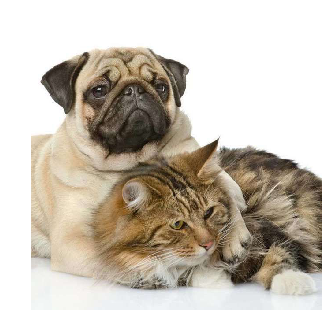

In [0]:
x_test.show(figsize=(x_test.size[0]/120,x_test.size[1]/120))

In [0]:
learn.predict(x_test)[0]

Category pug

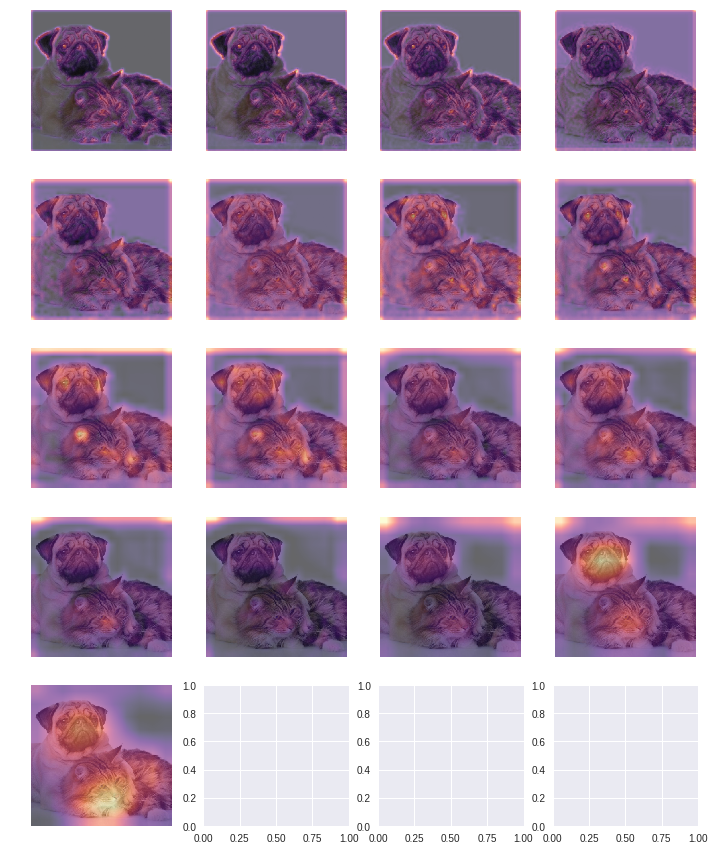

In [0]:
plot_non_class_discriminative_heatmaps_multi(x_test)

## Class-discriminative heat-maps along the network


In [0]:
def class_discriminative_gradients_multi(xb, cat):
    hooks_a = []
    hooks_g = []
    layer_names = []
    
    hooks_a.append(hook_output(m[0][3]))
    hooks_g.append(hook_output(m[0][3], grad=True))
    
    layer_names.append('first conv')

    for ind in [4,5,6,7]:
        for i,el in enumerate(learn.model[0][ind]):
            hooks_a.append(hook_output(el))
            hooks_g.append(hook_output(el, grad=True))
            layer_names.append(f'layer-{ind-3} - conv-{i+1}')
            # layer 1 (layer is combination of resnet blocks) is model[0][4]
    
    preds = m(xb)
    preds[0,int(cat)].backward()
    
    for hook in hooks_a:
        hook.remove()
        
    for hook in hooks_g:
        hook.remove()
    
    return hooks_a,hooks_g,layer_names

In [0]:
def plot_class_discriminative_heatmaps_multi(x,cat=None,relu=True):
    
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    if cat is None:
        y_to_get_gradients_for = y.data
    else:
        y_to_get_gradients_for = cat
    
    hooks_a,hooks_g,_ = class_discriminative_gradients_multi(xb,y_to_get_gradients_for)
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts = hooks_a[ind].stored[0].cpu()
            grad = hooks_g[ind].stored[0][0].cpu()

            grad_chan = grad.mean(1).mean(1)
            mult = (acts*grad_chan[...,None,None]).mean(0)

            if relu:
                mult = F.relu(mult)

            xb_im.show(ax[i,j])
            ax[i,j].imshow(mult, alpha=0.6, extent=(0,352,352,0),
                      interpolation='bilinear', cmap='magma');
            ind+=1
            
    plt.show()

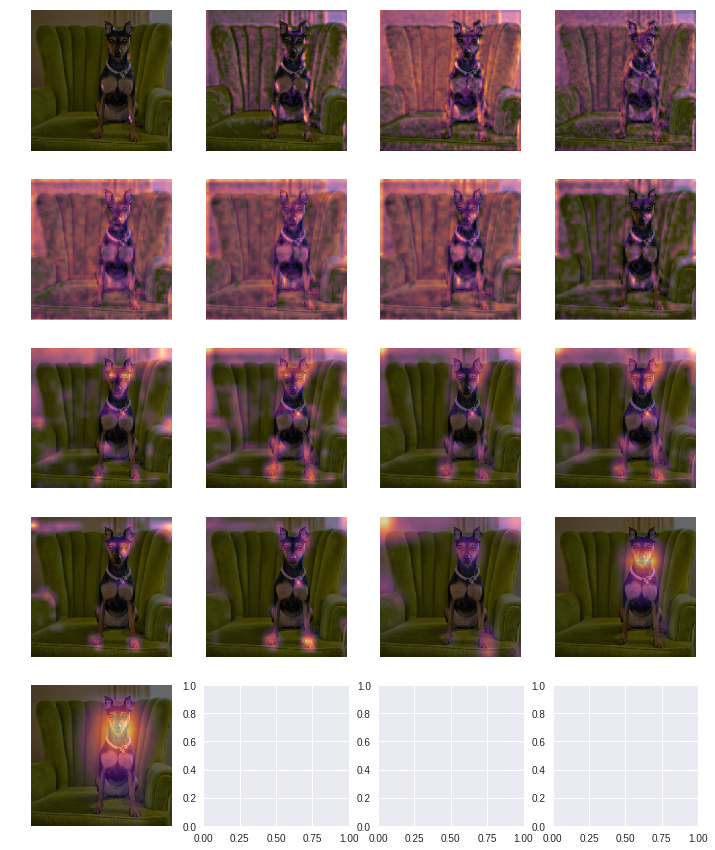

In [0]:
plot_class_discriminative_heatmaps_multi(x)

As expected, the class discriminative heat-maps are more concentrated especially in the last few layers of the network.

In [0]:
class_dict = {}
for i,el in enumerate(data.classes):
    class_dict[el.lower()] = i

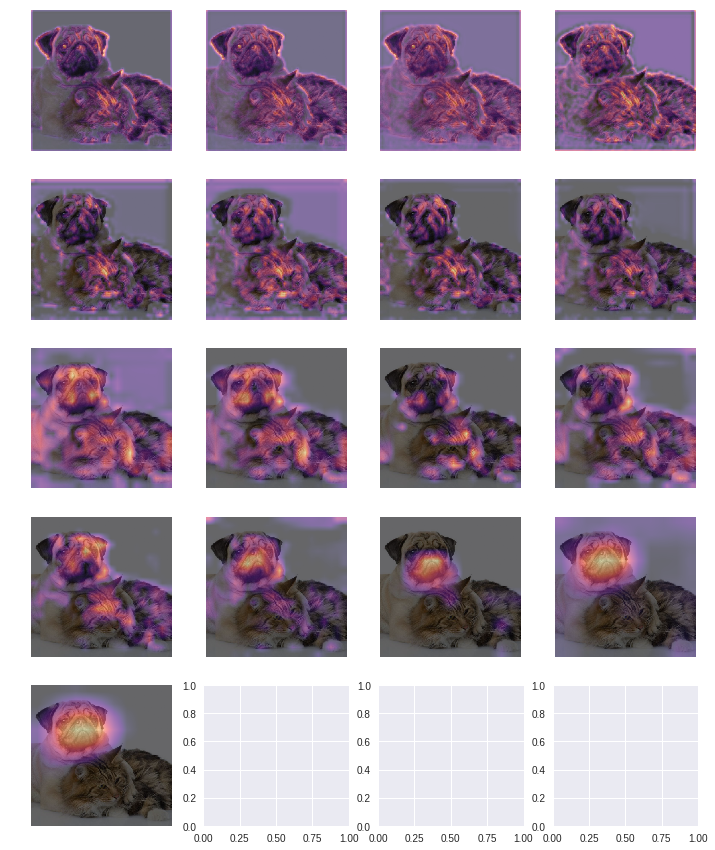

In [0]:
plot_class_discriminative_heatmaps_multi(x_test,class_dict['pug'])

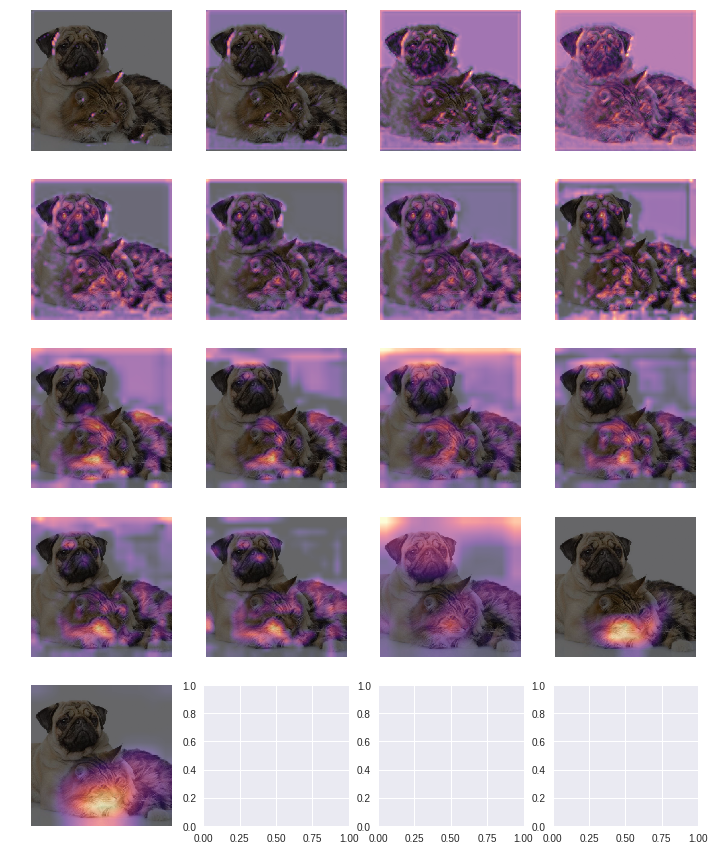

In [0]:
plot_class_discriminative_heatmaps_multi(x_test,class_dict['maine_coon'])

In [0]:
!wget https://i.ytimg.com/vi/SEAayLjjVOg/maxresdefault.jpg -O beagle_shiba.jpg

--2018-12-03 13:34:11--  https://i.ytimg.com/vi/SEAayLjjVOg/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 74.125.142.119, 74.125.195.119, 2607:f8b0:400e:c08::77
Connecting to i.ytimg.com (i.ytimg.com)|74.125.142.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152543 (149K) [image/jpeg]
Saving to: ‘beagle_shiba.jpg’

beagle_shiba.jpg    100%[===================>] 148.97K  --.-KB/s    in 0.002s  

2018-12-03 13:34:11 (60.6 MB/s) - ‘beagle_shiba.jpg’ saved [152543/152543]



In [0]:
fn = 'beagle_shiba.jpg'

In [0]:
x_test_2 = open_image(fn)

In [0]:
x_test_2.shape

torch.Size([3, 720, 1280])

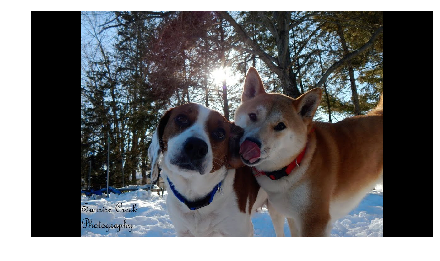

In [0]:
x_test_2.show(figsize=(x_test_2.size[0]/100,x_test_2.size[1]/100))

In [0]:
learn.predict(x_test_2)[0]

Category shiba_inu

The model classifies this image as `shiba_inu`.

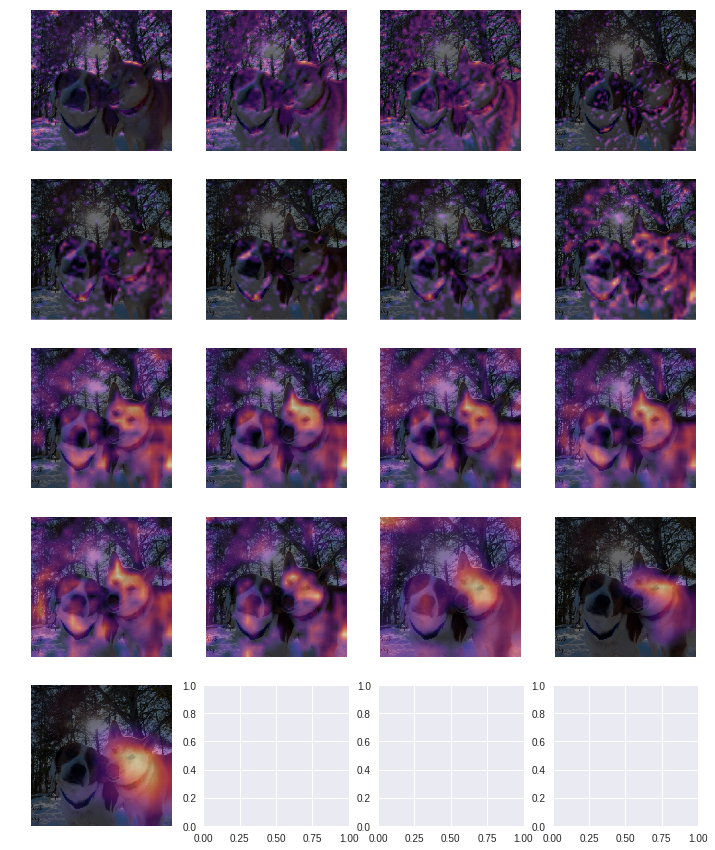

In [0]:
plot_class_discriminative_heatmaps_multi(x_test_2,class_dict['shiba_inu'])

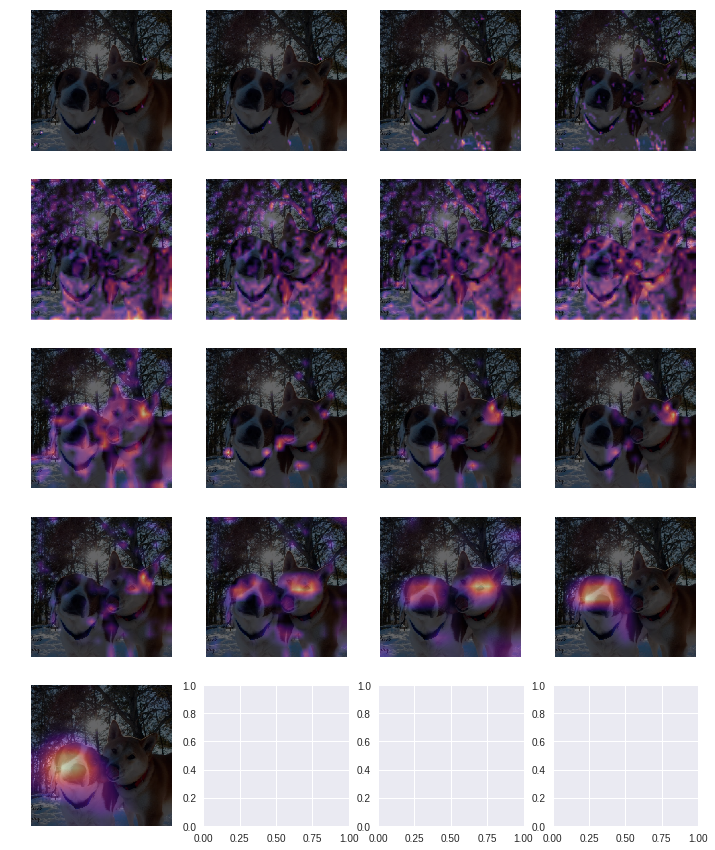

In [0]:
plot_class_discriminative_heatmaps_multi(x_test_2,class_dict['beagle'])

In [0]:
!wget https://previews.123rf.com/images/cynoclub/cynoclub1712/cynoclub171200076/91122699-puppy-saint-bernard-and-chihuahua-in-front-of-white-background.jpg -O saint_bernard_chihuahua.jpg

--2018-12-03 13:34:19--  https://previews.123rf.com/images/cynoclub/cynoclub1712/cynoclub171200076/91122699-puppy-saint-bernard-and-chihuahua-in-front-of-white-background.jpg
Resolving previews.123rf.com (previews.123rf.com)... 23.55.179.67
Connecting to previews.123rf.com (previews.123rf.com)|23.55.179.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92438 (90K) [image/jpeg]
Saving to: ‘saint_bernard_chihuahua.jpg’

saint_bernard_chihu 100%[===================>]  90.27K  --.-KB/s    in 0.05s   

2018-12-03 13:34:19 (1.83 MB/s) - ‘saint_bernard_chihuahua.jpg’ saved [92438/92438]



In [0]:
fn = 'saint_bernard_chihuahua.jpg'

In [0]:
x_test_3 = open_image(fn)

In [0]:
x_test_3.shape

torch.Size([3, 827, 1300])

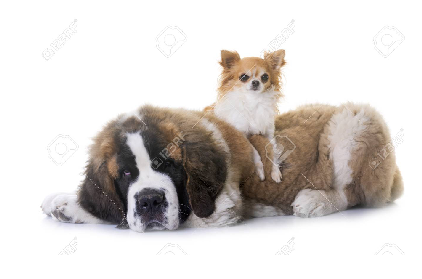

In [0]:
x_test_3.show(figsize=(x_test_3.size[0]/120,x_test_3.size[1]/120))

In [0]:
learn.predict(x_test_3)[0]

Category saint_bernard

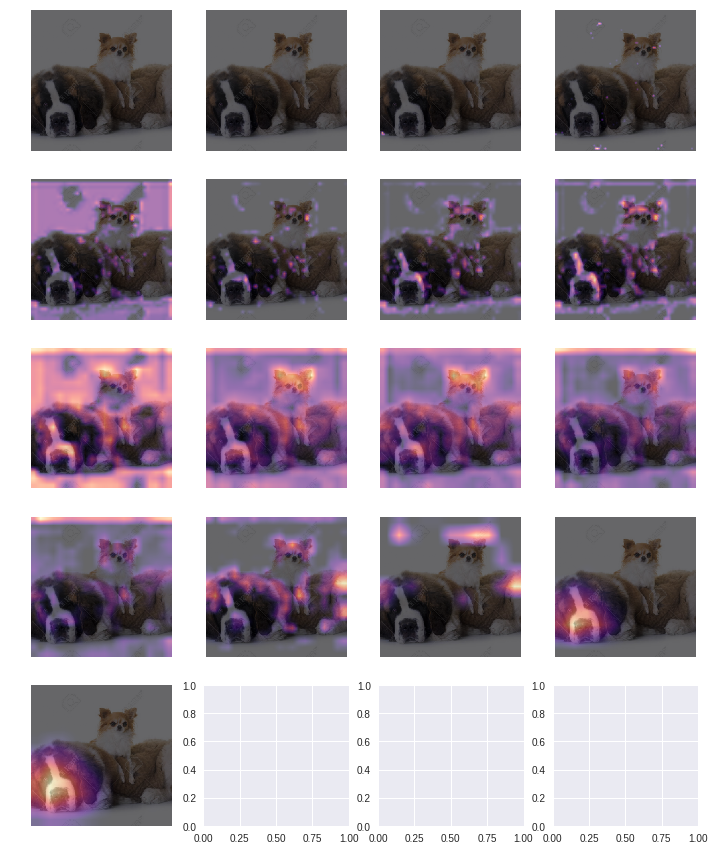

In [0]:
plot_class_discriminative_heatmaps_multi(x_test_3,cat=class_dict['saint_bernard'])

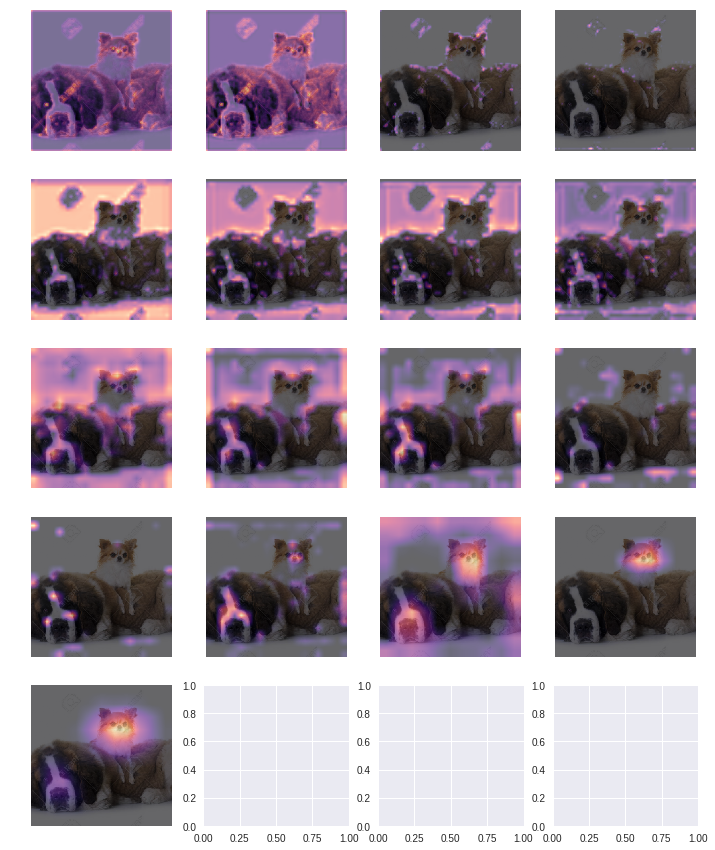

In [0]:
plot_class_discriminative_heatmaps_multi(x_test_3,class_dict['chihuahua'])

In [0]:
def get_class_discriminative_heatmap_animation(x,cat=None,relu=True):
    
    fig, ax = plt.subplots(1,2)
#     fig.set_size_inches(5,5)
    fig.tight_layout()
    plt.close()

    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()

    if cat is None:
        y_to_get_gradients_for = y.data
    else:
        y_to_get_gradients_for = cat

    hooks_a,hooks_g,layer_names = class_discriminative_gradients_multi(xb,y_to_get_gradients_for)

    ims = []
    
    xb_im.show(ax[0])

    for ind in range(len(hooks_a)):

        acts = hooks_a[ind].stored[0].cpu()
        grad = hooks_g[ind].stored[0][0].cpu()

        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        
        if relu:
            mult = F.relu(mult)
        
        im = ax[1].imshow(mult, alpha=1, extent=(0,352,352,0), interpolation='bilinear', cmap='magma', animated=True)

        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=400, blit=True,
                                    repeat_delay=1000, repeat=False)
    return ani

In [0]:
from IPython.display import HTML

In [0]:
ani = get_class_discriminative_heatmap_animation(x)
# rc('animation', html='jshtml')
# ani
HTML(ani.to_html5_video())

In [0]:
ani = get_class_discriminative_heatmap_animation(x_test_2,class_dict['shiba_inu'])
HTML(ani.to_html5_video())

In [0]:
ani = get_class_discriminative_heatmap_animation(x_test_2,class_dict['beagle'])
HTML(ani.to_html5_video())

In [0]:
ani = get_class_discriminative_heatmap_animation(x_test,class_dict['pug'])
HTML(ani.to_html5_video())

In [0]:
ani = get_class_discriminative_heatmap_animation(x_test,class_dict['maine_coon'])
HTML(ani.to_html5_video())

In [0]:
ani = get_class_discriminative_heatmap_animation(x_test_3,class_dict['saint_bernard'])
HTML(ani.to_html5_video())

In [0]:
ani = get_class_discriminative_heatmap_animation(x_test_3,class_dict['chihuahua'])
HTML(ani.to_html5_video())

## References:
- [Grad-CAM:
Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
- [fastai's Deep Learning Part-1 (2018) MOOC](https://www.fast.ai/)